<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/computer_vision/CV_and_Representation_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import requests
import numpy as np
from numpy import random

In [2]:
SEED = 42

# For reproducibility everywhere
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Download our [Dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10)

In [105]:
DATA_DIR = "./animal-10n"

In [4]:
!mkdir -p "./animal-10n"

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10 -p ./animal-10n

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
with zipfile.ZipFile("./animal-10n/animals10.zip", "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

### Learning some Italian! (?)

There's a `translate.py` file. As you can see, all the subdirectories of `/raw-img` are in italian for some reason. Those are our labels

In [7]:
import sys
sys.path.append(os.path.abspath("./animal-10n"))

In [8]:
from translate import translate

for (src, target) in translate.items():
    print(f"{src} -> {target}")

cane -> dog
cavallo -> horse
elefante -> elephant
farfalla -> butterfly
gallina -> chicken
gatto -> cat
mucca -> cow
pecora -> sheep
scoiattolo -> squirrel
dog -> cane
elephant -> elefante
butterfly -> farfalla
chicken -> gallina
cat -> gatto
cow -> mucca
spider -> ragno
squirrel -> scoiattolo


In [9]:
translate['ragno'] = 'spider' # They forgot to add this for some reason

## Looking at our class distribution

In [10]:
for animal_class in os.listdir("./animal-10n/raw-img"):
    print(f"{translate[animal_class]} -> {len(os.listdir(f'./animal-10n/raw-img/{animal_class}'))} images")

chicken -> 3098 images
squirrel -> 1862 images
cow -> 1866 images
butterfly -> 2112 images
dog -> 4863 images
elephant -> 1446 images
spider -> 4821 images
sheep -> 1820 images
horse -> 2623 images
cat -> 1668 images


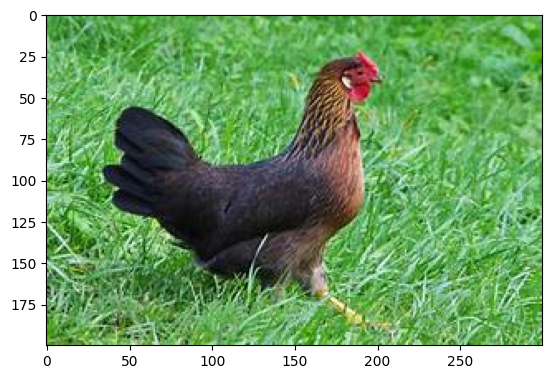

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

for animal_class in os.listdir("./animal-10n/raw-img")[:1]:
    for image_name in os.listdir(f'./animal-10n/raw-img/{animal_class}')[:1]:
        image = Image.open(f'./animal-10n/raw-img/{animal_class}/{image_name}')
        plt.imshow(image)
        plt.show()
        print(image.size)


## Data Transformation
Our images have (W, H, C) 300x200x3

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

(300, 200)


## Data Loader

In [13]:
BATCH_SIZE = 32
val_split = .2 # Test with 20%

### Using ImageFolder

```
    """A generic data loader where the images are arranged in this way by default: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png

    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.

    Args:
        root (str or ``pathlib.Path``): Root directory path.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
        allow_empty(bool, optional): If True, empty folders are considered to be valid classes.
            An error is raised on empty folders if False (default).

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """
```

In [14]:
dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "raw-img"), transform=transform)

### Split the data into test/train data

In [15]:
train_size = int((1 - val_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


#### Dataset after Data Augmentation:

In [17]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 20943
Validation dataset size: 5236


### Example use of Data Loader

In [18]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(labels[0])
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])
tensor(4)


In [19]:
classname_to_idx = dataset.class_to_idx
idx_to_classname = {v: translate[k] for k, v in classname_to_idx.items()}

In [20]:
print(idx_to_classname)

{0: 'dog', 1: 'horse', 2: 'elephant', 3: 'butterfly', 4: 'chicken', 5: 'cat', 6: 'cow', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


# Convolutional Neural Network -> Using ResNet50

In [21]:
import torch.nn as nn # Neural Network Modules
import torch.optim as optim # Optimizers
from torchvision import models # Baseline CV models
import torch.nn.functional as F # Functions that operate on Neural Network Modules

### ResNet50

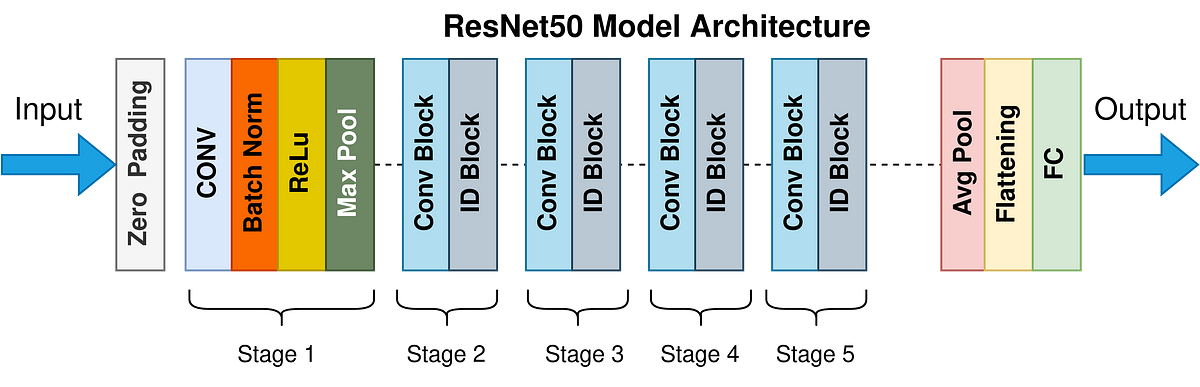

In [22]:
 _resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print(_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Note this part!**


```
(fc): Linear(in_features=2048, out_features=1000, bias=True)
```



In [24]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes): # We know that we have 10 animals
        super(CNN, self).__init__()
        self.resnet = models.resnet50()
        # This will change the final layer of the ResNet to (2048,) -> (10,)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


### Hook to Visualize Representations

In [25]:
activations = {}
def hook_fn(module, input, output):
    activations["penultimate"] = output.detach()

## Training

In [26]:
from tqdm.autonotebook import tqdm, trange

<ipython-input-26-a835f6bef373>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [27]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
model = CNN(num_classes=10) # 10 Animals
model.to(device)

CNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

### Cross-Entropy (Loss Function) and Adam (Optimizer)

- [Cross-Entropy's Wikipedia Page](https://en.wikipedia.org/wiki/Cross-entropy)

Logistic regression typically optimizes the log loss for all the observations on which it is trained, which is the same as optimizing the average cross-entropy in the sample. Other loss functions that penalize errors differently can be also used for training, resulting in models with different final test accuracy. For example, suppose we have $N$  samples with each sample indexed by $n=1,...,N$. The average of the loss function is then given by:

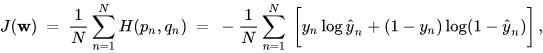


Where the probability of the output $y=1$:
$$
\hat y \equiv g(w\cdot x)=\frac{1}{1 + e^{-w\cdot x}}
$$

- [Adam Paper](https://arxiv.org/pdf/1412.6980)

```
@article{kingma2014adam,
  title={Adam: A method for stochastic optimization},
  author={Kingma, Diederik P},
  journal={arXiv preprint arXiv:1412.6980},
  year={2014}
}
```

Adam is a stable method for **Stochastic Gradient Descent**

$$
\text{Compute gradients:} \\ g_t = \nabla J(\theta_t) \\
\text{Update biased first moment estimate:} \\
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
\text{Update biased second moment estimate:} \\
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\text{Compute bias-corrected first and second moment estimates:}\\
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \\
\text{Update parameters:} \\
\theta_t = \theta_{t-1} - \alpha\frac{\hat m_t}{\sqrt{\hat v_t} + \epsilon}
$$

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training Loop

In [31]:
# We apply it on the second-to-last layer!
hook_handle = model.resnet.avgpool.register_forward_hook(hook_fn)

>In PyTorch, for every mini-batch during the training phase, we typically
want to explicitly set the gradients to zero before starting to do
backpropagation (i.e., updating the Weights and biases) because PyTorch
accumulates the gradients on subsequent backward passes. This accumulating
behavior is convenient while training RNNs or when we want to compute the
gradient of the loss summed over multiple mini-batches. So, the default
action has been set to accumulate (i.e. sum) the gradients on every `loss.backward()` call. Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch


In [32]:
model.train()

# For RL visualizations
activation_history = []

# Other stuff
train_loss_history = []
train_accuracy = []
validation_accuracy = []
validation_loss_history = []

# Outer loop: Number of times for running through the entire dataset
for epoch in trange(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_activations = []
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")
    # Inner loop: For each minibatch in the dataset
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        # Zero'ing the optimizer gradients (see above)
        optimizer.zero_grad()

        # Inference
        outputs = model(images)

        # Get second-to-last layer activations
        epoch_activations.append((activations["penultimate"], labels))

        # CORE LEARNING ALGORITHM HERE:
        # =============================
        loss = criterion(outputs, labels) # J_Θ
        loss.backward()
        optimizer.step() # Θ_t = Θ_t-1 + ⍺(∇J)
        # =============================

        # Recording Loss
        running_loss += loss.item()
        train_loss_history.append(loss.item())

        # Accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_bar.set_postfix(loss=running_loss/total, acc=correct/total)
        train_accuracy.append(correct/total)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Acc: {100*correct/total:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # We don't update our model here
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)

            # Recording Loss
            val_loss += loss.item()
            validation_loss_history.append(loss.item())

            # Accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_bar.set_postfix(loss=val_loss/total, acc=correct/total)
            validation_accuracy.append(correct/total)

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Acc: {100*correct/total:.2f}%")
    activation_history.append(epoch_activations)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.9077, Acc: 33.33%


Epoch 1/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.5926, Acc: 45.24%


Epoch 2/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.4265, Acc: 50.60%


Epoch 2/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.3623, Acc: 53.25%


Epoch 3/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.1991, Acc: 58.69%


Epoch 3/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.1787, Acc: 60.24%


Epoch 4/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.0527, Acc: 64.05%


Epoch 4/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.0856, Acc: 63.20%


Epoch 5/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9651, Acc: 67.11%


Epoch 5/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.0478, Acc: 65.36%


Epoch 6/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8667, Acc: 70.70%


Epoch 6/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 1.0362, Acc: 65.30%


Epoch 7/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7996, Acc: 72.79%


Epoch 7/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 0.8537, Acc: 71.10%


Epoch 8/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7422, Acc: 74.97%


Epoch 8/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 0.8338, Acc: 72.67%


Epoch 9/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6706, Acc: 77.70%


Epoch 9/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 0.8461, Acc: 71.96%


Epoch 10/10 [Training]:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6142, Acc: 79.09%


Epoch 10/10 [Validation]:   0%|          | 0/164 [00:00<?, ?it/s]

Validation Loss: 0.7879, Acc: 75.02%


#### Saving Checkpoint

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
save_path = "/content/drive/My Drive/animal10-resnet.pth"

torch.save(model.state_dict(), save_path)

## Visualizing Representation Learning

In [59]:
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

from IPython.display import HTML

In [34]:
NUM_SAMPLES = 1000

In [39]:
# Select the same 1000 points across all epochs
indices = np.random.choice(
    np.concatenate([batch[0].cpu().numpy() for batch in activation_history[0]], axis=0).shape[0],
    NUM_SAMPLES,
    replace=False
)

### With TSNE

- Article on [t-SNE](https://medium.com/@sachinsoni600517/mastering-t-sne-t-distributed-stochastic-neighbor-embedding-0e365ee898ea)

In [60]:
fixed_embeddings = []
fixed_labels = []

for epoch_activations in activation_history:
    activations = np.concatenate([batch[0].cpu().numpy() for batch in epoch_activations], axis=0)
    labels = np.concatenate([batch[1].cpu().numpy() for batch in epoch_activations], axis=0)

    sampled_activations = activations[indices].squeeze()
    sampled_labels = labels[indices]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=SEED)
    tsne_embeddings = tsne.fit_transform(sampled_activations)

    fixed_embeddings.append(tsne_embeddings)
    fixed_labels.append(sampled_labels)

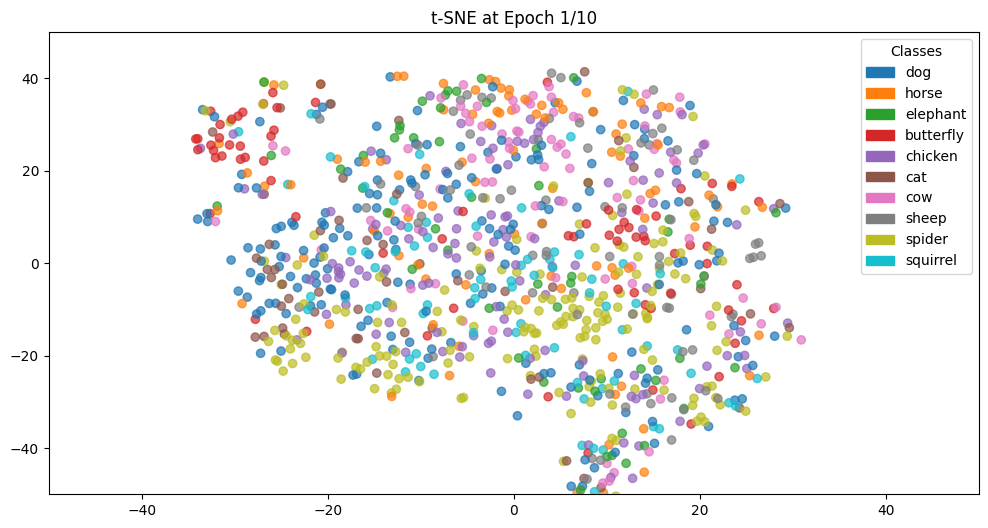

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

def update(frame):
    ax.clear()
    epoch_data = fixed_embeddings[frame]
    epoch_labels = fixed_labels[frame]

    sc = ax.scatter(epoch_data[:, 0], epoch_data[:, 1], c=epoch_labels, cmap="tab10", alpha=0.7)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_title(f"t-SNE at Epoch {frame+1}/{NUM_EPOCHS}")

    unique_labels = set(epoch_labels)
    patches = [mpatches.Patch(color=plt.cm.tab10(i / 10), label=idx_to_classname[i]) for i in unique_labels]
    ax.legend(handles=patches, loc="upper right", title="Classes")

    return sc,


ani = animation.FuncAnimation(fig, update, frames=NUM_EPOCHS, interval=500, repeat=True)

In [70]:
plt.tight_layout()
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [54]:
ani.save("latent_space_evolution_tsne.mp4", writer="ffmpeg", fps=2)

## Analyzing Training

In [97]:
epoch_starts_train = np.linspace(0, len(train_accuracy), NUM_EPOCHS, endpoint=False)[1:]
epoch_starts_val = np.linspace(0, len(validation_accuracy), NUM_EPOCHS, endpoint=False)[1:]

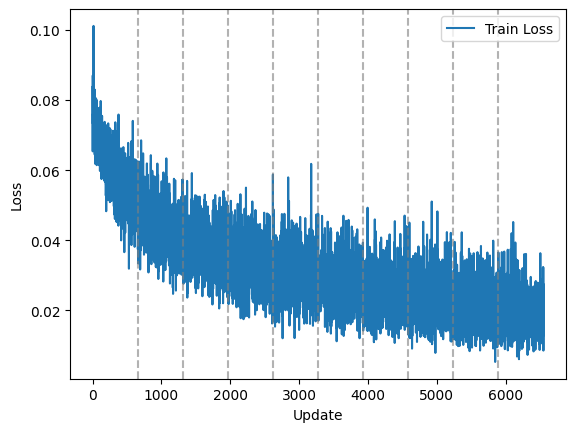

In [100]:
plt.plot([x/BATCH_SIZE for x in train_loss_history], label="Train Loss")
for epoch in epoch_starts_train:
    plt.axvline(x=epoch, color='gray', linestyle='--', alpha=0.6)
plt.xlabel("Update")
plt.ylabel("Loss")
plt.legend()
plt.show()

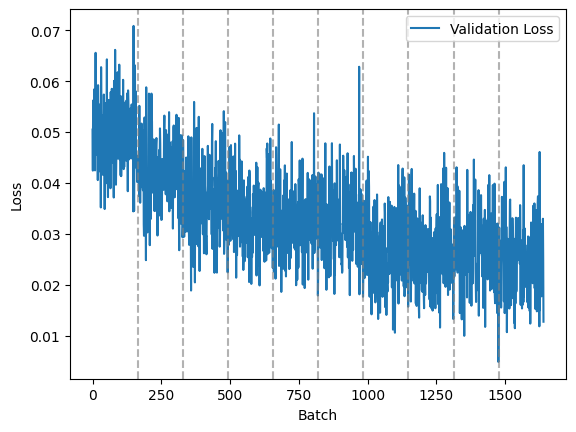

In [104]:
plt.plot([x/BATCH_SIZE for x in validation_loss_history], label="Validation Loss")
for epoch in epoch_starts_val:
    plt.axvline(x=epoch, color='gray', linestyle='--', alpha=0.6)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

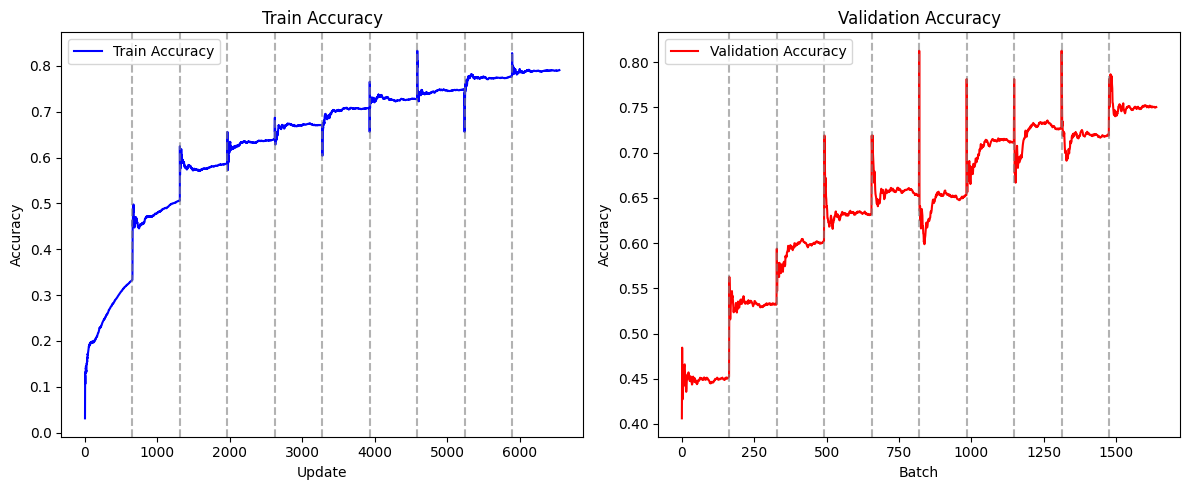

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_accuracy, label="Train Accuracy", color='blue')
for epoch in epoch_starts_train:
    axes[0].axvline(x=epoch, color='gray', linestyle='--', alpha=0.6)
axes[0].set_xlabel("Update")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Train Accuracy")
axes[0].legend()

axes[1].plot(validation_accuracy, label="Validation Accuracy", color='red')
for epoch in epoch_starts_val:
    axes[1].axvline(x=epoch, color='gray', linestyle='--', alpha=0.6)
axes[1].set_xlabel("Batch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


### And we're done! :)
```
Credits: @ghubnerr on GitHub
```